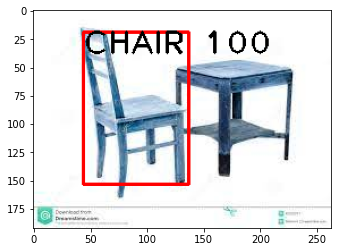

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tkinter
import customtkinter
from tkinter import filedialog as fd

cap=cv2.VideoCapture(0)

yolo_weights="./yolov3.weights"
yolo_configuration="./yolov3.cfg"
yolo=cv2.dnn.readNet(yolo_weights,yolo_configuration)

classes = []

with open("./coco.names",'r') as f:
    classes = f.read().splitlines()

def liveDetect():
    while True:
        success,image=cap.read()
        image=cv2.resize(image,(0,0),fx=0.5,fy=0.5)
        blob = cv2.dnn.blobFromImage(image, 1/255, (320,320), (0,0,0), swapRB=True, crop=False)
        width, height, _ = image.shape 
        i = blob[0].reshape(320,320,3)
        yolo.setInput(blob)
        output_layers_name = yolo.getUnconnectedOutLayersNames()
        layeroutput = yolo.forward(output_layers_name)
        boxes = []
        confidences = []
        class_ids = []

        for output in layeroutput:
            for detection in output:
                score = detection[5:]
                class_id = np.argmax(score)
                confidence = score[class_id]
                if confidence > 0.5:
                    center_x = int(detection[0]*height)
                    center_y = int(detection[1]*width)

                    h = int(detection[2]*height)
                    w = int(detection[3]*width)

                    x = int(center_x - h/2)
                    y = int(center_y - w/2)

                    boxes.append([x,y,w,h])
                    confidences.append(float(confidence))
                    class_ids.append(class_id)


        indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.3)

        for i in indexes.flatten():
            x,y,h,w = boxes[i]
            label = str(classes[class_ids[i]])
            confi = str(round(confidences[i]*100))

            cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),2)
            cv2.putText(image, label.upper() +" "+confi, (x,y+20), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,0), 2)

        cv2.imshow('Live',image)
        if(cv2.waitKey(1)&0xFF==ord('q')):
            break

    cap.release()
    cv2.destroyAllWindows()
    
def stillImageDetect():
    file1=fd.askopenfile(mode='r',filetype=[('jpg file','*.jpg')])
    img = cv2.imread(file1.name)
    blob = cv2.dnn.blobFromImage(img, 1/255, (320,320), (0,0,0), swapRB=True, crop=False)
    width, height, _ = img.shape 
    i = blob[0].reshape(320,320,3)
    yolo.setInput(blob)
    output_layers_name = yolo.getUnconnectedOutLayersNames()
    layeroutput = yolo.forward(output_layers_name)

    boxes = []
    confidences = []
    class_ids = []

    for output in layeroutput:
        for detection in output:
            score = detection[5:]
            class_id = np.argmax(score)
            confidence = score[class_id]
            if confidence > 0.5:
                center_x = int(detection[0]*height)
                center_y = int(detection[1]*width)
                h = int(detection[2]*height)
                w = int(detection[3]*width)

                x = int(center_x - h/2)
                y = int(center_y - w/2)

                boxes.append([x,y,w,h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.3)

    font = cv2.FONT_HERSHEY_PLAIN

    for i in indexes.flatten():
        x,y,w,h = boxes[i]

        label = str(classes[class_ids[i]])
        confi = str(round(confidences[i]*100))

        cv2.rectangle(img, (x,y), (x+h,y+w), (255,0,0), 2)
        cv2.putText(img, label.upper() +" "+confi, (x,y+20), font, 2, (0,0,0), 2)

    plt.imshow(img)

    cv2.imwrite("./img.jpg",img)
    
customtkinter.set_appearance_mode("dark")  # Modes: "System" (standard), "Dark", "Light"
customtkinter.set_default_color_theme("blue")  # Themes: "blue" (standard), "green", "dark-blue"

app = customtkinter.CTk()
app.geometry("500x280")
app.title("Object Detector")

frame_1 = customtkinter.CTkFrame(master=app)
frame_1.pack(pady=20, padx=60, fill="both", expand=True)

label_1 = customtkinter.CTkLabel(text="WELCOME TO OBJECT DETECTOR",master=frame_1, justify=tkinter.LEFT)
label_1.pack(pady=12, padx=10)

button_1 = customtkinter.CTkButton(master=frame_1, command=liveDetect, text="Live Detection")
button_1.pack(pady=12, padx=10)

button_2 = customtkinter.CTkButton(master=frame_1, command=stillImageDetect, text="Still Image entry")
button_2.pack(pady=12, padx=10)

label_2 = customtkinter.CTkLabel(text="If you selected Still Image Entry, \nkindly close this pop-up after selecting image" ,
                                 master=frame_1, justify=tkinter.CENTER)
label_2.pack(pady=12, padx=10)

app.mainloop()